<a href="https://colab.research.google.com/github/zubejda/Advanced_DL/blob/main/minimal_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alternatvie text](https://www.doc.zuv.fau.de//M/FAU-Logo/01_FAU_Kernmarke/Web/FAU_Kernmarke_Q_RGB_blue.svg)



# Assignment 3: Minimal GAN in PyTorch

Generative adversarial network (GAN) are well-known deep generative models proposed by [Ian Goodfellow](https://www.iangoodfellow.com) that could be used for synthesising data. It consists of two components, a generator (G) network that learns the data distribution and generates new examples and a discriminator (D) network that distinguishes between real and fake examples i.e. examples generated by G. In this assignment, you'll be asked to implement a series of tasks related to GANs using MNIST and Fashion-MNIST datasets. You upload your use a local python editor or python notebook e.g. Jupyter to implement your solution.

Prior to the assignment, it is necessary to install a package manager e.g. [conda](https://docs.conda.io/en/latest/), and [PyTorch](https://pytorch.org) framework.

## 1. Implement GAN in PyTorch


This public github [repository](https://github.com/bazilas/minimal-gan) implements GANs using tensorflow framework to reconstruct samples from MNIST and Fashion-MNIST data The first task is to re-implement the code (gan.py) using PyTorch framework instead. You should report your training performance i.e. train loss as a figure and another figure containing a batch of generated images after training.

In [1]:
import torch
import torchvision
import numpy
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

In [2]:
##load  MNIST

fashion_mnist = False

if fashion_mnist == False:
    dataset = datasets.MNIST('MNIST_data', train=True, download=True, transform=transforms.ToTensor())
else:
    dataset = datasets.FashionMNIST('Fashion-MNIST_data', train=True, download=True, transform=transforms.ToTensor())

data_loader = DataLoader(dataset, batch_size=100, shuffle=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4572188.12it/s]


Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 134451.80it/s]


Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1094712.03it/s]


Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3052480.17it/s]

Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



In [3]:
#setup generator
zdim = 50
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(zdim, 128),
            nn.ReLU(),
            nn.Linear(128, 784),
            nn.Sigmoid()
        )
    def forward(self, input):
        return self.main(input)

In [4]:
#setup discriminator
xdim = 784
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(xdim, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
        )
        self.prob = nn.Sigmoid()
    def forward(self, input):
        x = self.main(input)
        return x, self.prob(x)

In [5]:
# create a sample
def draw_sample(m, n):
    return numpy.random.uniform(-1.0, 1.0, size=[m, n])

In [6]:
def get_n_samples(data_loader, n):
    samples = []
    data_iter = iter(data_loader)

    while len(samples) < n:
        try:
            imgs, _ = next(data_iter)
            samples.append(imgs)
        except StopIteration:
            data_iter = iter(data_loader)

    samples = torch.cat(samples)[:n]
    return samples

In [7]:
#training loop
x = torch.tensor(draw_sample(1, 784), dtype=torch.float32).to(device)
z = torch.tensor(draw_sample(1, zdim), dtype=torch.float32).to(device)

G = Generator().to(device)
D = Discriminator().to(device)

G_sample_train = G(z)
D_logit_real, D_real = D(x)
D_logit_gen, D_fake = D(G_sample_train)
G_sample_inf = G(z)

criterion = nn.BCEWithLogitsLoss()

D_loss_real = criterion(D_logit_real, torch.ones_like(D_logit_real))
D_loss_gen = criterion(D_logit_gen, torch.zeros_like(D_logit_gen))
D_loss = D_loss_real + D_loss_gen

G_loss = criterion(D_logit_gen, torch.ones_like(D_logit_gen))

opt_g = optim.Adam(G.parameters(), lr=0.0002)
opt_d = optim.Adam(D.parameters(), lr=0.0002)

num_epochs = 200
batch_size = 32

In [13]:
test_samples = get_n_samples(data_loader, 9)
for epoch in range(num_epochs):
    for batch_idx, (real_imgs, _) in enumerate(data_loader):
        # Update discriminator
        real_imgs = real_imgs.view(-1, 784).to(device)
        z = torch.randn(batch_size, zdim).to(device)

        G_sample_train = G(z)
        D_logit_real, D_real = D(real_imgs)
        D_logit_gen, D_fake = D(G_sample_train)

        D_loss_real = criterion(D_logit_real, torch.ones_like(D_logit_real))
        D_loss_gen = criterion(D_logit_gen, torch.zeros_like(D_logit_gen))
        D_loss = D_loss_real + D_loss_gen

        opt_d.zero_grad()
        D_loss.backward()
        opt_d.step()

        # Update generator
        z = torch.randn(batch_size, zdim).to(device)
        G_sample_train = G(z)
        D_logit_gen, D_fake = D(G_sample_train)

        G_loss = criterion(D_logit_gen, torch.ones_like(D_logit_gen))

        opt_g.zero_grad()
        G_loss.backward()
        opt_g.step()

    if epoch % 20 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], D_loss: {D_loss.item():.4f}, G_loss: {G_loss.item():.4f}')
        noise = torch.tensor(draw_sample(9, zdim), dtype=torch.float32).to(device)
        samples = G(noise)
        fig = plt.figure(figsize=(10, 10))
        gs = gridspec.GridSpec(10, 10)
        for j, sample in enumerate(samples):
            sample = sample.detach().cpu().numpy()
            ax = plt.subplot(gs[j])
            ax.set_xticks([])
            ax.set_yticks([])
            plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

        plt.savefig('/content/res/{}.png'.format(str(epoch).zfill(4)), bbox_inches='tight')
        plt.close()

Epoch [0/200], D_loss: 0.3319, G_loss: 2.6797
Epoch [20/200], D_loss: 0.3184, G_loss: 3.1351
Epoch [40/200], D_loss: 0.4846, G_loss: 2.9719
Epoch [60/200], D_loss: 3.1502, G_loss: 1.5437
Epoch [80/200], D_loss: 0.4527, G_loss: 2.8019
Epoch [100/200], D_loss: 0.5625, G_loss: 3.0201
Epoch [120/200], D_loss: 0.4919, G_loss: 2.1899
Epoch [140/200], D_loss: 0.5968, G_loss: 2.4130
Epoch [160/200], D_loss: 0.5732, G_loss: 2.0282
Epoch [180/200], D_loss: 0.5778, G_loss: 2.1822


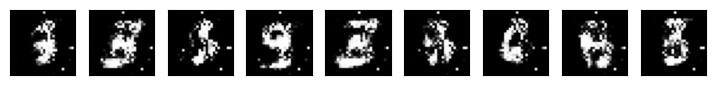

In [12]:
#plot losses and generated images
noise = torch.tensor(draw_sample(9, zdim), dtype=torch.float32).to(device)
samples = G(noise)
# samples = get_n_samples(data_loader, 9)
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(10, 10)
for j, sample in enumerate(samples):
    sample = sample.detach().cpu().numpy()
    ax = plt.subplot(gs[j])
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

plt.savefig('/content/res/{}.png'.format(str(j).zfill(7)), bbox_inches='tight')
plt.close()

## 2a. Implement GAN with Convolutional architecture.

Convolurional neural networks (CNNs) have a better feature representation, unlike, fully connected layers. Hence, it is required here to modify your code to include CNNs in your script. For more information, check out this [tutorial](https://gucifer.github.io/mediator/feature/2021/08/11/GAN-evaluation-using-FID-and-IS.html).

Similar to before, please report your training performance i.e. train loss as a figure and another figure containing a batch of generated images after training. You can plot one figure including and highlight the train loss using fully connected and CNN networks.

In [ ]:
import torch
import torchvision
import numpy
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


In [ ]:
#load MNIST

In [ ]:
#setup convolutional generator

In [ ]:
#etup convolutional discriminator

In [ ]:
#training loop

In [ ]:
#plot losses and generated images with the convolutional GAN

## 2b. now reimplement this with FASHION-MNIST with a convolutinal architecture

## 3. Conditional GAN (cGAN)

Vanilla GANs produce synthetic images by drawing a random vector from latent space. However, we may condition the GAN to additional information, namely, a class label e.g. label  "0" in MNIST. This requires to additionally input the label to G and D networks along with random vector drawn from latent space. You may use this [cGAN](https://learnopencv.com/conditional-gan-cgan-in-pytorch-and-tensorflow/) tutorial to implement a cGAN based on the convolutional archiecture you've implemented before. Furthermore, MNIST should be used in this task.

In [ ]:
#generator and discriminator

In [ ]:
#define training step for generator

#define training step for discriminator

In [ ]:
#training loop


In [ ]:
#plot looses and generated images along wth their conditions